In [198]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import datetime
import pandas as pd
import pyplot_themes as themes
import sys 


pd.options.mode.chained_assignment = None  # default='warn'
themes.theme_few(scheme='light')

plt.rcParams.update({'font.family':'Arial'})


In [199]:
N = 0
DATE_FINDER = 3

def make_max_value_dates(df, N):
    """Since it's not clear what the exact rumor day is, look at rumor days around GPT rumor day and get 
    the one with max value"""
    max_rumor_date = {}
    for uid in set(df['kwe'].tolist()):
        max_rumor_date[uid] = max_value_date_helper(df, uid, DATE_FINDER)
    return max_rumor_date

def max_value_date_helper(df, uid, N):
    df2 = df[df['kwe'] == uid]
    df2['abs_rumor_delta'] = np.abs(df2['rumor_delta'])
    filter_df = df2[df2['abs_rumor_delta'] <= N]
    max_date = filter_df.sort_values(['value', 'abs_rumor_delta'], ascending=False).head(1)['date'].tolist()[0]
    return max_date

def truncate_time(x, n):
    if abs(x) <= n:
        return 1 
    else:
        return 0


rumor_data = pd.read_json("../data/rum_data.json").T.reset_index()[['index', 'rumor_day', 'announce_day']]
df = pd.merge(left=pd.read_csv("../data/trend_data.csv"), right=rumor_data, left_on='event', right_on='index')
df = df[df['search_type'].isin(['web', "youtube"])]

# Make UID
df['kwe'] = df['kw'] + "_" + df['event']

# Get date difference between date and rumor, announcement day
df['rumor_delta'] = (pd.to_datetime(df['rumor_day']) - pd.to_datetime(df['date'])).dt.days.astype(int)
df['announce_delta'] = (pd.to_datetime(df['announce_day']) - pd.to_datetime(df['date'])).dt.days.astype(int)
max_value_rumor_dict = make_max_value_dates(df, 10)

# Also define a second rumor date 
df['rumor_day2'] = [max_value_rumor_dict[x] for x in df['kwe'].tolist()]
df['rumor2_delta'] = (pd.to_datetime(df['rumor_day2']) - pd.to_datetime(df['date'])).dt.days.astype(int)

# Various pivot tables
searchd = df.groupby(by=['event', 'date', 'search_type', 'rumor_day', 'rumor_day2', 'announce_day', 'rumor_delta', 'announce_delta']).mean().reset_index()
kwd = df.groupby(by=['event', 'date', 'kw', 'rumor_day', 'rumor_day2','announce_day', 'rumor_delta', 'announce_delta']).mean().reset_index()
eventd = df.groupby(by=['event', 'date', 'rumor_day', 'rumor_day2','announce_day', 'rumor_delta', 'announce_delta']).mean().reset_index()
event_search = df.groupby(by=['event', 'date', 'search_type', 'rumor_day', 'rumor_day2','announce_day', 'rumor_delta', 'announce_delta']).mean().reset_index()

for d in [df, kwd, eventd, searchd, event_search]:
    d['rumor_period'] = d['rumor_delta'].apply(lambda x: truncate_time(x, N))
    d['announce_period'] = d['announce_delta'].apply(lambda x: truncate_time(x, N))
    d['rumor2_period'] = d['rumor2_delta'].apply(lambda x: truncate_time(x, N))
    d['control_period'] = (d['rumor_period'] + d['announce_period']).apply(lambda x: 1 if x==0 else 0)
    d['control_period2'] = (d['rumor2_period'] + d['announce_period']).apply(lambda x: 1 if x==0 else 0)

    d['period'] = d.apply(lambda row: 'rumor_period' if row['rumor_period']==1 else ('announce_period' if row['announce_period']==1 else 'control'), axis=1)
    d['period2'] = d.apply(lambda row: 'rumor2_period' if row['rumor2_period']==1 else ('announce_period' if row['announce_period']==1 else 'control'), axis=1)

    d['year'] = pd.to_datetime(d['rumor_day']).dt.year
    if 'kw' in d.columns:
        d['val_prop'] = d['value']/d.groupby(['kw', 'event'])['value'].transform('sum')

In [200]:
np.abs(df['rumor_delta'])

0        30
1        29
2        28
3        27
4        26
         ..
16309    37
16310    38
16311    39
16312    40
16313    41
Name: rumor_delta, Length: 10876, dtype: int64

# Descriptive Plots

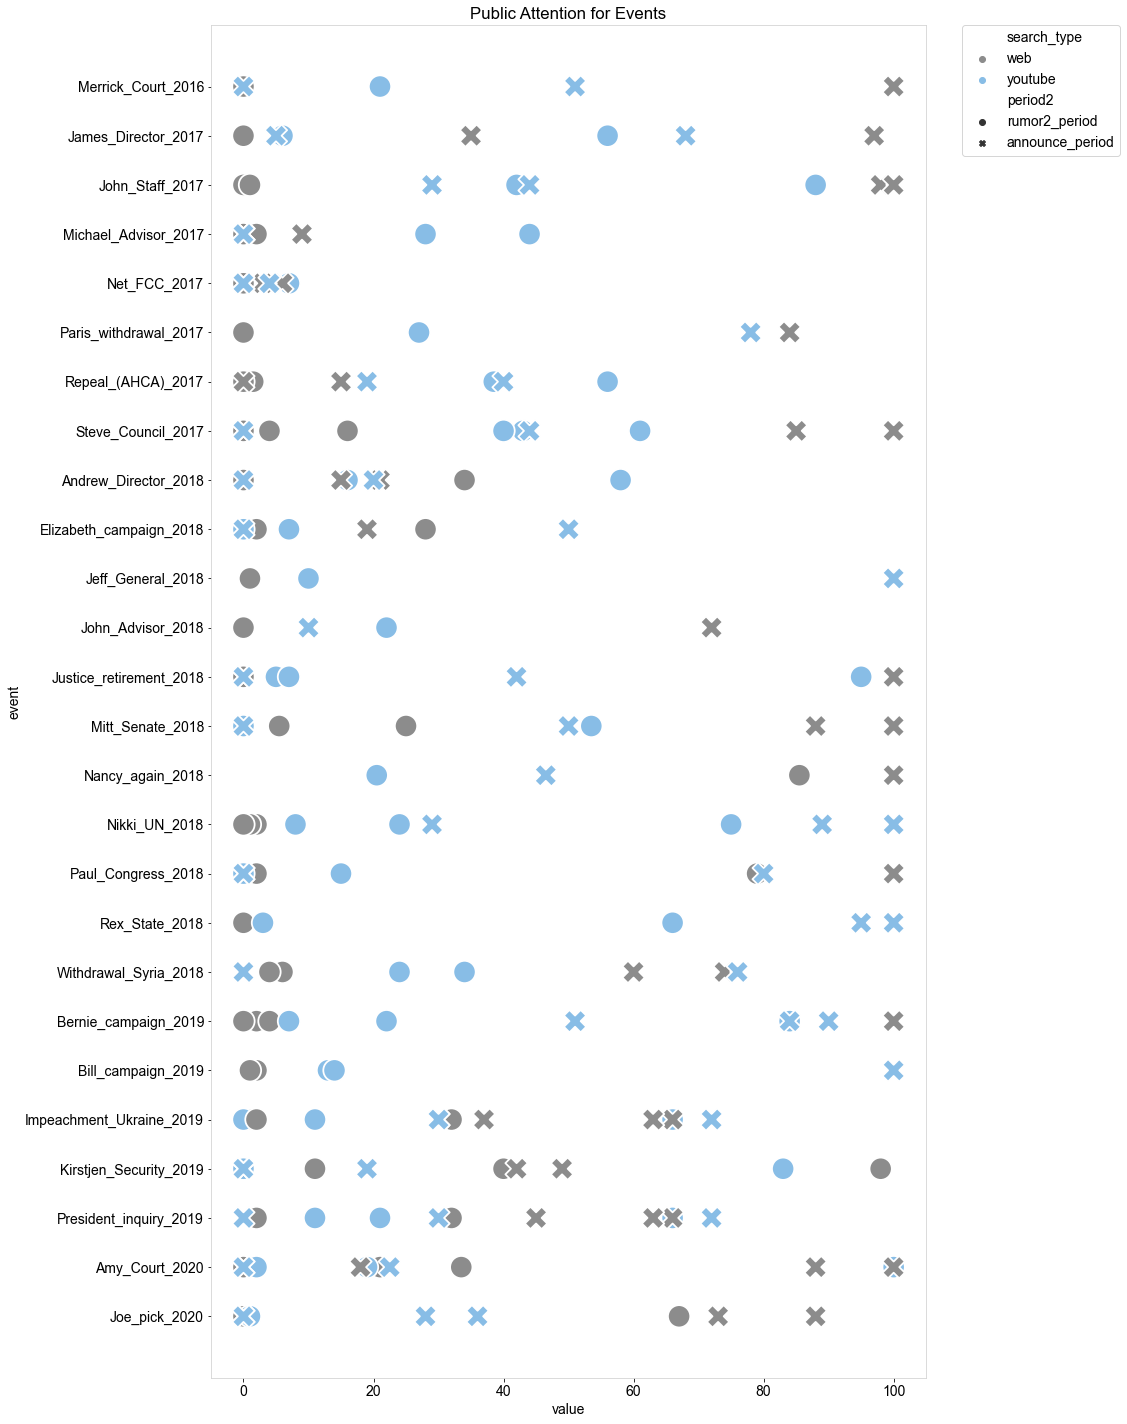

In [201]:
plt.figure(figsize=(16,20))
sns.scatterplot(data=event_search.query("control_period2==0").sort_values(by=['year', 'event']), y='event', s=500, x='value', style='period2', hue='search_type')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.title("Public Attention for Events")
plt.tight_layout()
plt.savefig("big_event.png", dpi=300)

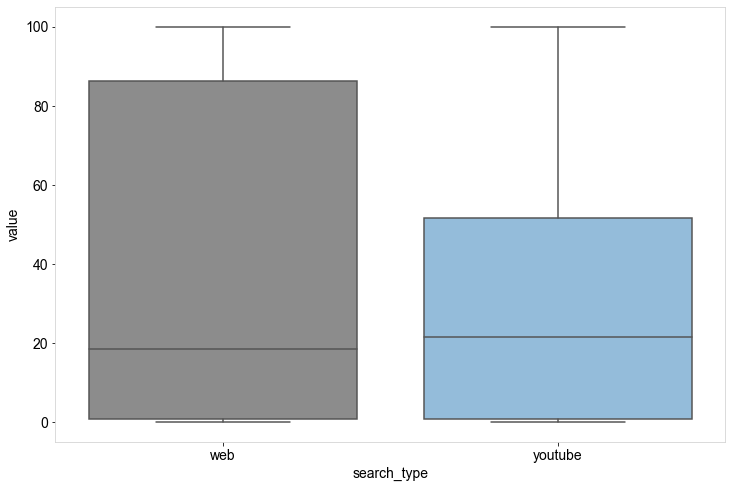

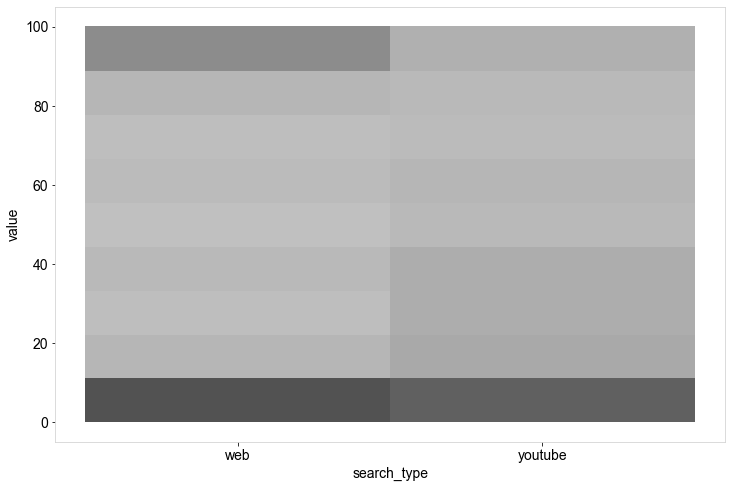

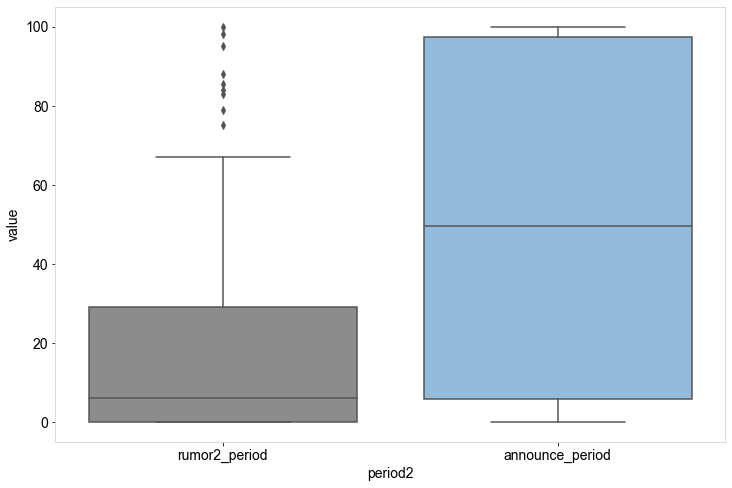

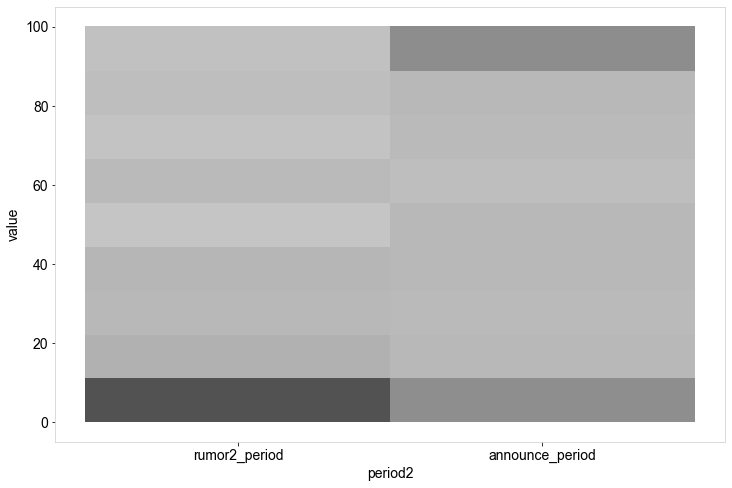

In [202]:
for break_out in ['search_type', 'period2']:

    sns.boxplot(data=event_search.query("control_period2==0"), x=break_out, y='value')
    plt.show()
    
    sns.histplot(data=event_search.query("control_period2==0"), x=break_out, y='value')
    plt.show()



# Announcement Period X Search Type

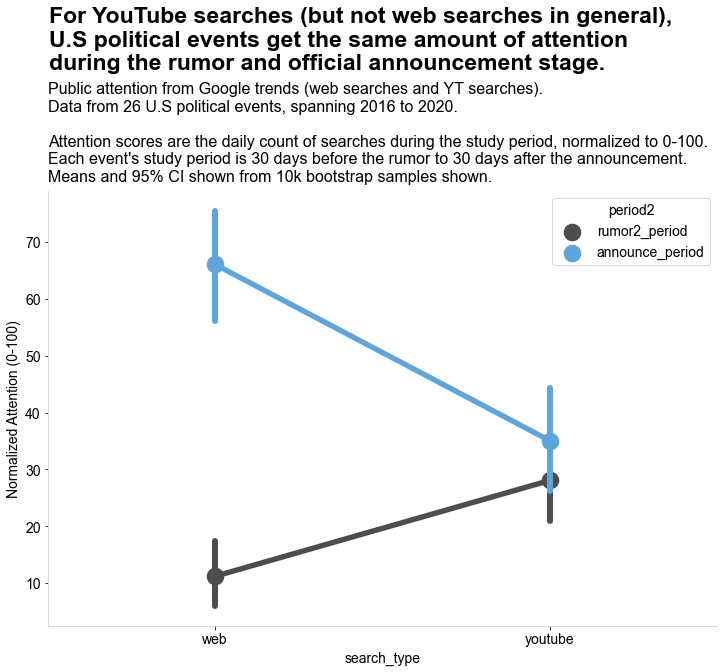

In [212]:
import matplotlib
from matplotlib.font_manager import FontProperties
import matplotlib.font_manager

themes.theme_few()
plt.rcParams.update({'font.family':'Arial'})

plt.figure(figsize=(12,8))

sns.pointplot(data=event_search.query("control_period2==0"), 
              errwidth=6, 
              errorbar='ci', 
              scale=2, 
              seed=416,
              n_boot=10000,
              hue='period2', 
              x='search_type', 
              y='value')


plt.ylabel("Normalized Attention (0-100)")
plt.title(
    (f"""\nPublic attention from Google trends (web searches and YT searches).\nData from {event_search['event'].nunique()} U.S political events, spanning {np.min(event_search['year'])} to {np.max(event_search['year'])}.\n\nAttention scores are the daily count of searches during the study period, normalized to 0-100.\nEach event's study period is 30 days before the rumor to 30 days after the announcement.\nMeans and 95% CI shown from 10k bootstrap samples shown."""),
    fontsize=16,
    pad=10,
    loc="left",
)

plt.suptitle(
    "For YouTube searches (but not web searches in general), \nU.S political events get the same amount of attention\nduring the rumor and official announcement stage.",
    fontsize=23,
    fontweight="bold",
    x=0.126,
    y=1.2,
    ha="left",
)

sns.despine()
plt.savefig("attn_interaction.png", dpi=300, bbox_inches='tight')


# Mixed Model (use R for any real analysis)

In [190]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [191]:
df['kwe'] = df['kw'] + df['event']
tdf = df.query("control_period==0")
md = smf.mixedlm("value ~ year + period*search_type", tdf, groups=tdf['kwe']).fit()

In [192]:
md.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                              Mixed Linear Model Regression Results
==================================================================================================
Model:                          MixedLM               Dependent Variable:               value     
No. Observations:               256                   Method:                           REML      
No. Groups:                     64                    Scale:                            659.2475  
Min. group size:                4                     Log-Likelihood:                   -1200.9837
Max. group size:                4                     Converged:                        Yes       
Mean group size:                4.0                                                               
--------------------------------------------------------------------------------------------------
                                                Coef.   Std.Err.    z    P>|z|   [0.025    0.975] 
--------------------------------------------------------------------------------------------------
Intercept                                     -5139.687 4372.904  -1.175 0.240 -13710.421 3431.047
period[T.rumor_period]                          -59.109    4.539 -13.023 0.000    -68.005  -50.213
search_type[T.youtube]                          -31.406    4.539  -6.919 0.000    -40.302  -22.510
period[T.rumor_period]:search_type[T.youtube]    32.188    6.419   5.014 0.000     19.607   44.768
year                                              2.580    2.167   1.191 0.234     -1.667    6.827
Group Var                                       140.369    2.460                                  
==================================================================================================

"""